# Ray

**Ray** - это унифицированный фреймворк с открытым исходным кодом для масштабирования приложений искусственного интеллекта и Python. Он обеспечивает вычислительный уровень для параллельной обработки. Ray минимизирует сложность запуска распределенных индивидуальных и end-to-end рабочих процессов машинного обучения с помощью следующих компонентов:

- Масштабируемые библиотеки для распространенных задач машинного обучения, таких как предварительная обработка данных, распределенное обучение, настройка гиперпараметров и обучение с подкреплением.

- Примитивы распределенных вычислений на Python для распараллеливания и масштабирования приложений на Python.

- Интеграции и утилиты для совмещения и развертывания кластера Ray с существующими инструментами и инфраструктурой, такими как Kubernetes, AWS, GCP и Azure.

**Функционал**:

- Предоставление вычислительных абстракции для создания масштабируемой и надежной ML-платформы
- Распараллеливание и распределение рабочих ML-нагрузок по нескольким узлам и графическим процессорам
- Предоставление унифицированного ML API, который упрощает внедрение и интеграцию с более широкой экосистемой ML
- Удобное взаимодействие разработки и производства, можно легко масштабировать код на Python с ноутбука на больший кластер
- Управление различными компонентами распределенной системы
- Планирование – координация того, когда и где выполняются задачи
- Отказоустойчивость – обеспечение выполнения задач
- Автоматическое масштабирование - перенастройка выделяемого количества ресурсов в соответствии с динамическим спросом

# Использование Ray

## Batch Inference

Batch inference - это процесс генерации предсказаний модели на больших "партиях" входных данных.

Ray работает с любыми облачными провайдерами и ML фреймворками, масштабировать код можно с минимальными изменениями  


![Batch inference](batch_inference.png)

## Пример использования Batch inference

*Image Classification Batch Inference with PyTorch*

**1. Считывание датасета**

In [1]:
# pip install -q "ray[data]" torch torchvision

In [2]:
# pip install grpcio

In [43]:
import ray

s3_uri = "s3://anonymous@air-example-data-2/imagenette2/train/"

ds = ray.data.read_images(s3_uri, mode="RGB")
ds

2023-11-26 14:07:06,492	INFO plan.py:757 -- Using autodetected parallelism=200 for stage ReadImage to satisfy DataContext.get_current().min_parallelism=200.


Dataset(
   num_blocks=200,
   num_rows=9469,
   schema={image: numpy.ndarray(ndim=3, dtype=uint8)}
)

**2. Вычисление результатов на основе партии данных**

Сначала создадим партию из 10 изображений датасета, каждое из которых представляет из себя Numpy array

In [44]:
single_batch = ds.take_batch(10)

2023-11-26 14:07:13,477	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=200 for stage ReadImage to satisfy DataContext.get_current().min_parallelism=200.
2023-11-26 14:07:13,478	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> LimitOperator[limit=10]
2023-11-26 14:07:13,479	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-26 14:07:13,480	INFO streaming_executor.py:107 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

Визуализируем изображение из партии:

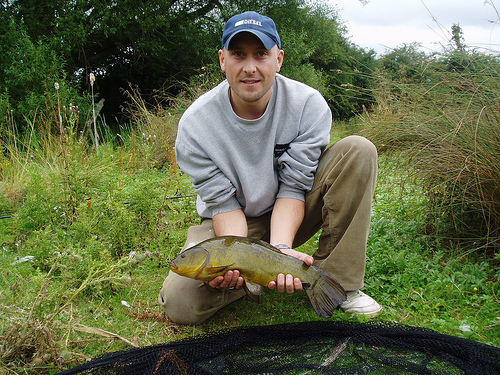

In [45]:
from PIL import Image

img = Image.fromarray(single_batch["image"][0])
img

Теперь загрузим предварительно обученную PyTorch Resnet модель и получим необходимые преобразования, чтобы обработать изображения перед прогнозированием

In [6]:
import torch
from torchvision.models import ResNet152_Weights
from torchvision import transforms
from torchvision import models

weights = ResNet152_Weights.IMAGENET1K_V1

# Загружаем предварительно обученную resnet модель и перемещаем в GPU (графический процессор) если он доступен

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(weights=weights).to(device)
model.eval()

imagenet_transforms = weights.transforms
transform = transforms.Compose([transforms.ToTensor(), imagenet_transforms()])

Теперь применим преобразования к партии изображений и передадим ее в модель для предсказаний, убеждаясь, что используется при этом GPU

Видим, что большая часть изображений была правильно классифицирована

In [7]:
transformed_batch = [transform(image) for image in single_batch["image"]]
with torch.inference_mode():
    prediction_results = model(torch.stack(transformed_batch).to(device))
    classes = prediction_results.argmax(dim=1).cpu()

del model  # Освобождаем память GPU

labels = [weights.meta["categories"][i] for i in classes]
labels

/Users/avo-milas/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


['tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'bittern',
 'tench']

## Parallel training

Параллельное обучение довольно часто используется в машинном обучении, когда необходимо обучить несколько моделей на разных подмножествах одного и того же датасета. Это идет в противопоставление тому, чтобы обучать одну модель на всем датасете сразу.

Если модель, которую вы хотите обучить, может поместиться на одном графическом процессоре, Ray способен назначить каждый сеанс обучения отдельному Ray Task. Таким образом, используются все доступные работники для обучения независимых процессов, а не один работник, выполняющий задания последовательно.

Это может позволить сэкономить время на обучение

![Batch inference](parallel_training.png)

## Пример использования Parallel training

В качестве примера будем обучать отдельные регрессионные модели для предсказания продолжительности поездки на такси: разные модели для разных конечных локаций в Нью-Йорке

Установим необходимые пакеты, импортируем библиотеки:

In [8]:
# !pip install -q "ray[tune]" scikit-learn xgboost

In [9]:
import os
import pickle
from tempfile import TemporaryDirectory

print(f"Number of CPUs in this system: {os.cpu_count()}")
from typing import Tuple, List, Union, Optional, Callable
import time
import pandas as pd
import numpy as np

print(f"numpy: {np.__version__}")
import pyarrow
import pyarrow.parquet as pq
import pyarrow.dataset as pds

print(f"pyarrow: {pyarrow.__version__}")

Number of CPUs in this system: 10
numpy: 1.24.3
pyarrow: 11.0.0


In [10]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-11-26 14:03:00,766	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.5
Ray version:,2.8.0
Dashboard:,http://127.0.0.1:8265


In [11]:
print(ray.cluster_resources())

{'memory': 14652561818.0, 'CPU': 10.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0}


In [12]:
import sklearn
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

print(f"sklearn: {sklearn.__version__}")
import xgboost as xgb

print(f"xgboost: {xgb.__version__}")

from ray import train, tune
from ray.train import Checkpoint


np.random.seed(42)

sklearn: 1.3.0
xgboost: 2.0.1


**1. Считываем и обрабатываем данные**

In [13]:
# определим глобальные переменные
TARGET = "trip_duration"
s3_partitions = pds.dataset(
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/",
    partitioning=["year", "month"],
)
s3_files = [f"s3://anonymous@{file}" for file in s3_partitions.files]

starting_idx = -1
sample_locations = [141, 229, 173]

s3_files = s3_files[starting_idx:]
print(f"NYC Taxi using {len(s3_files)} file(s)!")
print(f"s3_files: {s3_files}")
print(f"Locations: {sample_locations}")

NYC Taxi using 1 file(s)!
s3_files: ['s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/06/data.parquet/ab5b9d2b8cc94be19346e260b543ec35_000000.parquet']
Locations: [141, 229, 173]


In [14]:
def read_data(file: str, sample_id: np.int32) -> pd.DataFrame:

    df = pq.read_table(
        file,
        filters=[
            ("passenger_count", ">", 0),
            ("trip_distance", ">", 0),
            ("fare_amount", ">", 0),
            ("pickup_location_id", "not in", [264, 265]),
            ("dropoff_location_id", "not in", [264, 265]),
            ("dropoff_location_id", "=", sample_id),
        ],
        columns=[
            "pickup_at",
            "dropoff_at",
            "pickup_location_id",
            "dropoff_location_id",
            "passenger_count",
            "trip_distance",
            "fare_amount",
        ],
    ).to_pandas()

    return df


def transform_df(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()

    df["trip_duration"] = (df["dropoff_at"] - df["pickup_at"]).dt.seconds
    df = df[df["trip_duration"] > 60]
    df = df[df["trip_duration"] < 24 * 60 * 60]
    # keep only necessary columns
    df = df[
        ["dropoff_location_id", "passenger_count", "trip_distance", "trip_duration"]
    ].copy()
    df["dropoff_location_id"] = df["dropoff_location_id"].fillna(-1)
    return df

**2.Определим функцию, которую будем вызывать для тренировки и оценки**

Определим функцию, которую будем вызывать для тренировки и оценки модели на кусочке датасета, она будет вызываться параллельно для каждой возможной комбинации параметров

In [15]:
def train_model(config: dict) -> None:

    algorithm = config["algorithm"]
    sample_location_id = config["location"]

    df_list = [read_data(f, sample_location_id) for f in s3_files]
    df_raw = pd.concat(df_list, ignore_index=True)

    df = transform_df(df_raw)

    if df.shape[0] < 10:
        print_time(f"Location {sample_location_id} has only {df.shape[0]} rows.")
        train.report(dict(error=None))
        return None

    train_df, valid_df = train_test_split(df, test_size=0.2, shuffle=True)
    train_X = train_df[["passenger_count", "trip_distance"]]
    train_y = train_df[TARGET]
    valid_X = valid_df[["passenger_count", "trip_distance"]]
    valid_y = valid_df[TARGET]

    model = algorithm.fit(train_X, train_y)
    pred_y = model.predict(valid_X)

    error = sklearn.metrics.mean_absolute_error(valid_y, pred_y)

    state_dict = {"model": algorithm, "location_id": sample_location_id}
    
    with TemporaryDirectory() as tmpdir:
        with open(os.path.join(tmpdir, "ckpt.pkl"), 'wb') as file:
            pickle.dump(state_dict, file)
    
        checkpoint = Checkpoint.from_directory(tmpdir)

        metrics = dict(error=error)
        train.report(metrics, checkpoint=checkpoint)

**3. Запускаем параллельное обучение**

In [16]:
# определяем всевозможные комбинации параметров (search space)
search_space = {
    "algorithm": tune.grid_search(
        [LinearRegression(fit_intercept=True), xgb.XGBRegressor(max_depth=4)]
    ),
    "location": tune.grid_search(sample_locations),
}

start = time.time()

# Определяем tuner object
tuner = tune.Tuner(
    train_model,
    param_space=search_space,
    run_config=train.RunConfig(
        name="batch_tuning",
    ),
)

results = tuner.fit()

total_time_taken = time.time() - start
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {total_time_taken/60:.2f} minutes")

2023-11-26 14:03:46,557	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'algorithm': ('__ref_ph', 'ef946eca')}
(train_model pid=66182) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/avo-milas/ray_results/batch_tuning/train_model_62fcf_00004_4_algorithm=ref_ph_ef946eca,location=173_2023-11-26_14-03-10/checkpoint_000000)
2023-11-26 14:03:47,294	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'algorithm': ('__ref_ph', 'b9b71cde')}
2023-11-26 14:03:49,341	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'algorithm': ('__ref_ph', 'b9b71cde')}
2023-11-26 14:03:52,259	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'algorithm': ('__ref_ph', 'ef946eca')}
(train_model pid=66180) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users

Total number of models: 6
TOTAL TIME TAKEN: 1.58 minutes


**4. Определяем наилучшую модель для каждой конечной точки поездки**

In [17]:
errors = [i.metrics.get("error", 10000.0) for i in results]
locations = [i.config["location"] for i in results]
algorithms = [i.config["algorithm"] for i in results]
results_df = pd.DataFrame(
    zip(locations, errors, algorithms),
    columns=["location_id", "error", "algorithm"],
)
results_df

,location_id,error,algorithm
0,141,513.273840,LinearRegression()
1,141,502.070418,"XGBRegressor(base_score=None, booster=None, ca..."
2,229,535.959108,LinearRegression()
3,229,570.533249,"XGBRegressor(base_score=None, booster=None, ca..."
4,173,1315.283921,LinearRegression()
5,173,1802.904684,"XGBRegressor(base_score=None, booster=None, ca..."


In [18]:
# оставляем только одну модель на локацию с минимальной ошибкой
final_df = results_df.copy()
final_df = final_df.loc[(final_df.error > 0), :]
final_df = final_df.loc[final_df.groupby("location_id")["error"].idxmin()]
final_df.sort_values(by=["error"], inplace=True)
final_df.set_index("location_id", inplace=True, drop=True)
final_df

,error,algorithm
location_id,,
141,502.070418,"XGBRegressor(base_score=None, booster=None, ca..."
229,535.959108,LinearRegression()
173,1315.283921,LinearRegression()


## Model serving

Акторы в Ray - вычислительные единицы, которые выполняются асинхронно и обеспечивают распределенное выполнение задач; объекты, которые могут содержать состояние, данные и методы для выполнения операций.

Ray Serve, в свою очередь, поддерживает развертывание моделей с использованием различных шаблонов, требующих оркестрации нескольких акторов. Ray Serve используется для создания сложных сервисов вывода, объединяющих несколько моделей машинного обучения и бизнес-логику.

Ray Serve способен масштабироваться до тысяч моделей в условиях реальной эксплуатации.

![Batch inference](multi_model_serve.png)

## Пример использования model serving

Развернем модель перевода текста с английского на французский с использованием Ray Serve, чтобы ее можно было масштабировать и обращаться к ней по HTTP. Начнем с преобразования Translator в объект развертывания Ray Serve:

In [19]:
# pip install starlette
# !pip install "ray[serve]"

In [20]:
from starlette.requests import Request

import ray
from ray import serve

In [21]:
from transformers import pipeline


@serve.deployment(num_replicas=2, ray_actor_options={"num_cpus": 0.2, "num_gpus": 0})
class Translator:
    def __init__(self):
        # Load model
        self.model = pipeline("translation_en_to_fr", model="t5-small")

    def translate(self, text: str) -> str:
        model_output = self.model(text)

        translation = model_output[0]["translation_text"]
        return translation

    async def __call__(self, http_request: Request) -> str:
        english_text: str = await http_request.json()
        return self.translate(english_text)



Класс Translator имеет две модификации:

1) Добавлен декоратор @serve.deployment
2) Добавлен новый метод call

Декоратор преобразует Translator из обычного класса Python в объект развертывания Ray Serve.

Каждое развертывание хранит одну функцию или класс и использует их для обслуживания запросов. Развертывания можно масштабировать и настраивать независимо, используя параметры в декораторе @serve.deployment. 

Примеры параметров:


- num_replicas: целое число, определяющее, сколько копий процесса развертывания запускается в Ray. Запросы балансируются между этими репликами, что позволяет масштабировать развертывания горизонтально.

- ray_actor_options: словарь, содержащий параметры конфигурации для каждой реплики:

        num_cpus: число, представляющее количество центральных процессоров, которое каждая реплика должна резервировать
        num_gpus: число, представляющее количество графических процессоров, которое каждая реплика должна резервировать

Метод call обрабатывает входящий HTTP-запрос, считывая его JSON-данные и передавая их в метод translate. Переведенный текст возвращается и отправляется в ответе HTTP.

Далее необходимо связать Translator с аргументами, которые будут переданы в его конструктор. Это определяет приложение Ray Serve, которое можно запустить локально или развернуть в продакшене. Поскольку конструктор Translator не принимает аргументов, мы можем вызвать метод bind, не передавая в него ничего:

In [22]:
translator_app = Translator.bind()

#### Запуск приложения Ray serve

Для локального тестирования запускаем скрипт:

`Имя файла: serve_quickstart.py`

```
from starlette.requests import Request

import ray
from ray import serve

from transformers import pipeline


@serve.deployment(num_replicas=2, ray_actor_options={"num_cpus": 0.2, "num_gpus": 0})
class Translator:
    def __init__(self):
        self.model = pipeline("translation_en_to_fr", model="t5-small")

    def translate(self, text: str) -> str:
        model_output = self.model(text)
        translation = model_output[0]["translation_text"]

        return translation

    async def __call__(self, http_request: Request) -> str:
        english_text: str = await http_request.json()
        return self.translate(english_text)


translator_app = Translator.bind()
```

в терминале выполняем команду, которая запустит выполнение приложения translator_app:

> serve run serve_quickstart:translator_app

Отправим POST реквест с JSON, содержащим английский текст. `__call__` метод Translator'a распакует текст и передаст его в метод перевода.
Клиентский скрипт, который запрашивает перевод текста "Hello world!"

`Имя файла: model_client.py`

```
import requests

english_text = "Hello world!"

response = requests.post("http://127.0.0.1:8000/", json=english_text)
french_text = response.text

print(french_text)
```

Чтобы протестировать, необходимо сначала запустить Translator:

> serve run serve_deployment:translator_app

Пока Translator запущен, открываем дополнительное окно терминала и запускаем клиентский скрипт, который получит ответ через HTTP:

> python model_client.py

Вывод:

> Bonjour monde!

#### Смешивание нескольких моделей

Развернем пайплайн с двумя моделями: саммаризация англиского текста и перевод на французский

Добавим саммаризатор:


`Имя файла: serve_quickstart_composed.py`

```
from starlette.requests import Request

import ray
from ray import serve
from ray.serve.handle import DeploymentHandle

from transformers import pipeline


@serve.deployment
class Translator:
    def __init__(self):
        self.model = pipeline("translation_en_to_fr", model="t5-small")

    def translate(self, text: str) -> str:
        model_output = self.model(text)
        translation = model_output[0]["translation_text"]
        return translation


@serve.deployment
class Summarizer:
    def __init__(self, translator):
        self.model = pipeline("summarization", model="t5-small")
        self.translator: DeploymentHandle = translator.options(use_new_handle_api=True)

    def summarize(self, text: str) -> str:
        model_output = self.model(text, min_length=5, max_length=15)
        summary = model_output[0]["summary_text"]

        return summary

    async def __call__(self, http_request: Request) -> str:
        english_text: str = await http_request.json()
        summary = self.summarize(english_text)

        translation = await self.translator.translate.remote(summary)
        return translation


app = Summarizer.bind(Translator.bind())
```

В данном скрипте Summarizer содержит метод `__call__`, поскольку реквест посылается в этот класс, класс также содержит Translator как аргумент конструктора

```self.translator.translate.remote(summary)``` вызывает асинхронно метод translate объекта Translator и возвращает объект DeploymentResponse сразу. Вызов оператора ```await``` для ответа ожидает выполнения удаленного метода call и впоследствии возвращает его значение.


Клиентский скрипт запроса:

`Имя файла: composed_client.py`

```
import requests

english_text = (
    "It was the best of times, it was the worst of times, it was the age "
    "of wisdom, it was the age of foolishness, it was the epoch of belief"
)
response = requests.post("http://127.0.0.1:8000/", json=english_text)
french_text = response.text

print(french_text)
```

Аналогично запускаем команды через терминал в двух окнах:

> serve run serve_quickstart_composed:app

Запуск клиентского скрипта:

> python composed_client.py

Вывод:

> c'était le meilleur des temps, c'était le pire des temps .


## Hyperparameter Tuning

Запуск нескольких экспериментов по настройке гиперпараметров является распространенным паттерном для распределенных вычислений, поскольку каждый эксперимент является независимым от других.

Ray Tune предоставляет ключевые функции, такие как создание контрольных точек для лучшего результата, оптимизация планирования и указание шаблонов поиска гиперпараметров.

![tuning_use_case](tuning_use_case.png)

## Пример использования Hyperparameter Tuning

In [23]:
# pip install "ray[tune]" torch torchvision

#### Определение, тренировка и оценивание модели

In [24]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

Определим простую модель PyTorch, которую будем тренировать.
В примере будет использована небольшая свёрточная нейронная сеть, состоящая из одного свёрнутого 2D слоя, полностью связанного слоя и функции softmax.

In [25]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

#### Тренировка и оценка модели

In [26]:
EPOCH_SIZE = 512
TEST_SIZE = 256

def train_func(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

#### Настраиваем Tuner

Определяем функцию, которая обучает модель PyTorch. Эта функция будет выполняться в отдельном акторе, поэтому необходимо сообщить Tune (который находится в основном процессе Python) значение показателя производительности модели.

Для этого мы вызываем train.report() в нашей функции обучения, которая отправляет значение производительности обратно в Tune.

In [27]:
def train_mnist(config):
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train_func(model, optimizer, train_loader)
        acc = test_func(model, test_loader)

        train.report({"mean_accuracy": acc})

        if i % 5 == 0:
            torch.save(model.state_dict(), "./model.pth")

Запустим одну попытку, вызвав метод Tuner.fit и случайным образом выбрав значения для learning rate и momentum из равномерного распределения.

In [28]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
}

datasets.MNIST("~/data", train=True, download=True)

tuner = tune.Tuner(
    train_mnist,
    param_space=search_space,
)
results = tuner.fit()

2023-11-26 14:04:48,060	INFO tune.py:1047 -- Total run time: 2.33 seconds (2.32 seconds for the tuning loop).


Tuner.fit вовзращает объект ResultGrid. Можно использовать это, чтобы визуализировать производительность данной попытки.

[<Axes: >]

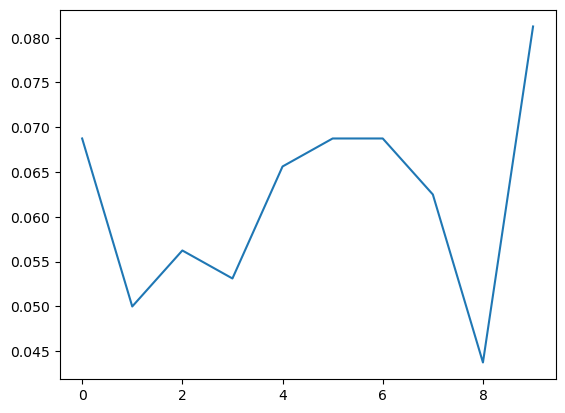

In [29]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]

#### Early Stopping with Adaptive Successive Halving (ASHAScheduler)

Интегрируем преждевременное завершение в процесс оптимизации, для этого будем использовать ASHA, масштабируемый алгоритм для преждевременного завершения. 

ASHA останавливает те попытки, которые являются менее обещающими и аллоцирует больше ресурсов и времени тем попыткам, которые "подают надежду". По мере того, как процесс оптимизации становится более эффективным, можно увеличить сетку поиска.

ASHA имплементирован в Tune как “Trial Scheduler”. Trial Schedulers могут обрывать неудачные попытки, ставить их на паузу, клонировать их и менять гиперпараметры запущенных попыток.

In [30]:
tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(
        num_samples=20,
        scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    ),
    param_space=search_space,
)
results = tuner.fit()

dfs = {result.path: result.metrics_dataframe for result in results}

2023-11-26 14:04:52,589	INFO tune.py:1047 -- Total run time: 4.28 seconds (4.24 seconds for the tuning loop).


Визуализируем процесс:

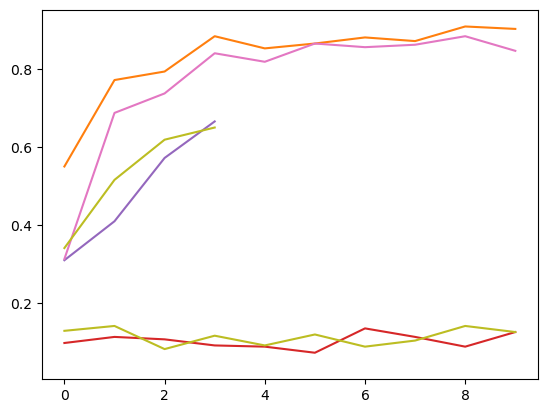

In [31]:
ax = None
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)

## Reinforcement Learning



![Reinforcement Learning](rllib_use_case.png)

RLlib - это библиотека с открытым исходным кодом для обучения с подкреплением (Reinforcement Learning, RL), предоставляющая поддержку для высокораспределенных рабочих нагрузок.

RLlib предоставляет класс Algorithm, который содержит полиси для взаимодействия с окружением. Через интерфейс Algorithm можно обучать полиси, вычислять действия или сохранять алгоритмы. В обучении с несколькими агентами алгоритм управляет запросами и оптимизацией нескольких полиси одновременно.

*(**Полиси** определяет, какие действия агент должен предпринять в различных состояниях среды)*

![Reinforcement Learning](ray_api.jpg)

## Пример использования Reinforcement Learning

#### Использование API Python

Python API предоставляет необходимую гибкость для применения RLlib к новым задачам. Например, нужно использовать API, если необходимо использовать пользовательские среды, предобработчики или модели с RLlib.

Пример: создаем PPOConfig и добавляем свойства, такие как среда, которую мы хотим использовать, или ресурсы, которые мы хотим использовать для обучения.


*PPOConfig обозначает конфигурацию для алгоритма PPO (Proximal Policy Optimization), который является одним из алгоритмов обучения с подкреплением - улучшение полиси агента путем прямой оптимизации функции полиси. Конфигурация содержит настройки, параметры и характеристики, которые определяют, как будет выполняться процесс обучения.*


После построения алгоритма из его конфигурации можно обучить его на определенном количестве эпизодов (в данном случае 5) и периодически сохранять полученную полиси (здесь каждые 2 эпизода).








In [32]:
# pip install gymnasium

In [33]:
# pip install tree

*Если будут возникать ошибки с модулем tree, то выполнить это в терминале:*
    
```
pip uninstall tree
pip uninstall dm-tree

pip install --upgrade ray
pip install dm-tree

```

In [34]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.tune.logger import pretty_print


algo = (
    PPOConfig()
    .rollouts(num_rollout_workers=1)
    .resources(num_gpus=0)
    .environment(env="CartPole-v1")
    .build()
)

for i in range(5):
    result = algo.train()
    print(pretty_print(result))

    if i % 2 == 0:
        checkpoint_dir = algo.save().checkpoint.path
        print(f"Checkpoint saved in directory {checkpoint_dir}")

2023-11-26 14:04:53,011	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
/Users/avo-milas/anaconda3/lib/python3.11/site-packages/ray/rllib/algorithms/algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/avo-milas/anaconda3/lib/python3.11/site-packages/ray/tune/logger/uni

agent_timesteps_total: 4000
connector_metrics:
  ObsPreprocessorConnector_ms: 0.0014898512098524305
  StateBufferConnector_ms: 0.0010297033521864149
  ViewRequirementAgentConnector_ms: 0.07378419240315755
counters:
  num_agent_steps_sampled: 4000
  num_agent_steps_trained: 0
  num_env_steps_sampled: 4000
  num_env_steps_trained: 0
custom_metrics: {}
date: 2023-11-26_14-05-00
done: false
episode_len_mean: 22.06111111111111
episode_media: {}
episode_reward_max: 90.0
episode_reward_mean: 22.06111111111111
episode_reward_min: 8.0
episodes_this_iter: 180
episodes_total: 180
hostname: avo-milas-x
info:
  learner:
    __all__:
      num_agent_steps_trained: 128.0
      num_env_steps_trained: 4000.0
      total_loss: 7.482139610786682
    default_policy:
      curr_entropy_coeff: 0.0
      curr_kl_coeff: 0.30000001192092896
      curr_lr: 5.0e-05
      default_optimizer_lr: 5.000000000000001e-05
      entropy: 0.6773339281839602
      mean_kl_loss: 0.02130767279731247
      policy_loss: -0.027

agent_timesteps_total: 12000
connector_metrics:
  ObsPreprocessorConnector_ms: 0.0015158653259277344
  StateBufferConnector_ms: 0.0009534358978271484
  ViewRequirementAgentConnector_ms: 0.07291889190673828
counters:
  num_agent_steps_sampled: 12000
  num_agent_steps_trained: 0
  num_env_steps_sampled: 12000
  num_env_steps_trained: 0
custom_metrics: {}
date: 2023-11-26_14-05-13
done: false
episode_len_mean: 52.84
episode_media: {}
episode_reward_max: 159.0
episode_reward_mean: 52.84
episode_reward_min: 10.0
episodes_this_iter: 57
episodes_total: 349
hostname: avo-milas-x
info:
  learner:
    __all__:
      num_agent_steps_trained: 128.0
      num_env_steps_trained: 4000.0
      total_loss: 9.154688227151249
    default_policy:
      curr_entropy_coeff: 0.0
      curr_kl_coeff: 0.30000001192092896
      curr_lr: 5.0e-05
      default_optimizer_lr: 5.000000000000001e-05
      entropy: 0.6045887637367127
      mean_kl_loss: 0.01072780832704441
      policy_loss: -0.019009638196433278
    

agent_timesteps_total: 20000
connector_metrics:
  ObsPreprocessorConnector_ms: 0.0015864372253417969
  StateBufferConnector_ms: 0.0009601116180419922
  ViewRequirementAgentConnector_ms: 0.07283878326416016
counters:
  num_agent_steps_sampled: 20000
  num_agent_steps_trained: 0
  num_env_steps_sampled: 20000
  num_env_steps_trained: 0
custom_metrics: {}
date: 2023-11-26_14-05-25
done: false
episode_len_mean: 118.27
episode_media: {}
episode_reward_max: 442.0
episode_reward_mean: 118.27
episode_reward_min: 17.0
episodes_this_iter: 16
episodes_total: 392
hostname: avo-milas-x
info:
  learner:
    __all__:
      num_agent_steps_trained: 128.0
      num_env_steps_trained: 4000.0
      total_loss: 9.761196632629265
    default_policy:
      curr_entropy_coeff: 0.0
      curr_kl_coeff: 0.15000000596046448
      curr_lr: 5.0e-05
      default_optimizer_lr: 5.000000000000001e-05
      entropy: 0.5826286010142329
      mean_kl_loss: 0.010422903818774924
      policy_loss: -0.010340826604257164
 

## ML Platform

Ray и его библиотеки искусственного интеллекта предоставляют объединенную среду выполнения для тех, кто стремится упростить свою платформу машинного обучения. Библиотеки Ray, такие как Ray Train, Ray Data и Ray Serve, можно использовать для компоновки end-to-end ML воркфлоу, они предоставляют функции и API для предварительной обработки данных в рамках обучения и перехода от обучения к обслуживанию.

Например, *[Merlin](https://shopify.engineering/merlin-shopify-machine-learning-platform) - платформа Shopify, которая построена на Ray. Она обеспечивает быстрые итерации и масштабирование распределенных приложений, таких как классификация продуктов и рекомендации.*



![Reinforcement Learning](ml_platform.png)

## Управление и координация выполнения больших объемов задач или рабочих процессов в распределенной системе

Рассмотрим в качестве примера веб-скрапер, параллелизуя его с использованием Ray.

Для скрапера будем использовать Beautiful Soup:

In [35]:
# pip install "beautifulsoup4==4.11.1" "ray>=2.2.0"

Сначала определим функцию с именем `find_links`, которая принимает стартовую страницу (start_url) для обхода, и для примера возьмем документацию Ray в качестве такой отправной точки. Веб-скрапер просто извлекает все доступные ссылки с начального URL, содержащие заданный base_url (например, в нашем примере мы хотим следовать только по ссылкам на http://docs.ray.io, а не по всем внешним ссылкам). Функция `find_links` вызывается рекурсивно со всеми найденными таким образом ссылками, пока не будет достигнута определенная глубина.

Чтобы извлечь ссылки из HTML-элементов на сайте, мы определяем вспомогательную функцию с именем `extract_links`, которая заботится о правильной обработке относительных URL и устанавливает ограничение на количество ссылок, возвращаемых с сайта (max_results), чтобы управлять временем выполнения веб-скрапера более удобно.

реализация:

In [36]:
import requests
from bs4 import BeautifulSoup

def extract_links(elements, base_url, max_results=100):
    links = []
    for e in elements:
        url = e["href"]
        if "https://" not in url:
            url = base_url + url
        if base_url in url:
            links.append(url)
    return set(links[:max_results])


def find_links(start_url, base_url, depth=2):
    if depth == 0:
        return set()

    page = requests.get(start_url)
    soup = BeautifulSoup(page.content, "html.parser")
    elements = soup.find_all("a", href=True)
    links = extract_links(elements, base_url)

    for url in links:
        new_links = find_links(url, base_url, depth-1)
        links = links.union(new_links)
    return links

Определим стартовый и базовый URL и заскрапим Ray docs до глубины 2:

In [37]:
base = "https://docs.ray.io/en/latest/"
docs = base + "index.html"

In [38]:
%time len(find_links(docs, base))

CPU times: user 2.05 s, sys: 217 ms, total: 2.27 s
Wall time: 6.29 s


957

Скрапинг документа рекурсивно возвращает в общей сложности 957 страниц.

Скрапинг страниц можно запараллелить по-разному, самый простой способ - начать с нескольких стартовых URL и параллельно вызывать find_links для каждого из них. Воспользуемся Ray Tasks: декоратор ray.remote для обертывания функции find_links в таск, который называется `find_links_task`

In [39]:
import ray

@ray.remote
def find_links_task(start_url, base_url, depth=2):
    return find_links(start_url, base_url, depth)

Чтобы использовать этот таск и запустить параллельный вызов, нужно вызывать `find_links_tasks.remote(...)`

Здесь запускается 6 скраперов параллельно, первые три снова на docs.ray.io, для остальных 3 точки входа - библиотеки Ray RLlib, Tune и Serve, соответственно:

In [40]:
links = [find_links_task.remote(f"{base}{lib}/index.html", base)
         for lib in ["", "", "", "rllib", "tune", "serve"]]

In [41]:
%time for res in ray.get(links): print(len(res))

957
957
957
262
103
101
CPU times: user 99.7 ms, sys: 1.02 s, total: 1.12 s
Wall time: 36.8 s


Этот параллельный запуск выполняет скрапинг занимает времени не пропорционально больше (в меньшее число раз тратится больше времени) увеличению числа стартовых точек (и страниц соответственно) по сравнению с последовательным запуском.